In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


You are looking to take a trip from August first to August seventh of this year, but are worried that the weather will be less than ideal. Using historical data in the dataset find out what the temperature has previously looked like.

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
# calculate minimum, average and maximum for a year between 07/08/2016 and 07/08/2017
min_avg_max = calc_temps('2016-08-07', '2017-08-07')
print(min_avg_max)

[(58.0, 74.64993394980185, 87.0)]


In [11]:
# create a dataframe for plotting 

min_avg_max_df = pd.DataFrame (data = min_avg_max, columns = ["tmin", "tavg", "tmax"])
min_avg_max_df

,tmin,tavg,tmax
0,58.0,74.649934,87.0


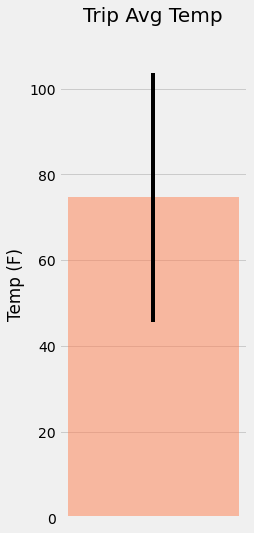

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# plot one year to 07/08/2017

plt.figure(figsize=[3,8])
plt.title("Trip Avg Temp", size=20, y=1.05)
plot_date = dt.datetime(2017,8,7)
plot_tmin = min_avg_max_df["tmin"]
plot_tavg = min_avg_max_df["tavg"]
plot_tmax = min_avg_max_df["tmax"]
peak_to_peak = min_avg_max_df["tmax"] - min_avg_max_df["tmin"]
plot = plt.bar("2017-08-07", plot_tavg, yerr = peak_to_peak , color = "coral", alpha=.5)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.grid(axis = 'x')
plt.savefig("Output/Trip_Avg_Temp.png", bbox_inches = 'tight')


### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date = dt.date(2017,8,1)
trip_end_date = dt.date(2017,8,7)
one_yr = dt.timedelta(days=365)
last_yr_start = trip_start_date - one_yr
last_yr_end = trip_end_date - one_yr



In [14]:
# run query to obtain data for the trip period using the previous year's matching dates
stations_data = session.query(Station.station,\
                 func.sum(Measurement.prcp),\
                 Station.name,\
                 Station.latitude,\
                 Station.longitude,\
                 Station.elevation).\
                 filter(Measurement.station == Station.station).\
                 filter(Measurement.date >= last_yr_start).\
                 filter(Measurement.date <= last_yr_end).\
                 group_by(Station.station).\
                 order_by(func.sum(Measurement.prcp).desc())


In [15]:
# display rainfall by station for the selted period
print(f"Total amount of rainfall per weather station between 01-08-2016 and 07-08-2016")
for row in stations_data:
    rainfall = "{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rainfall}  \n    Location:  {row[2]}\n    Latitude:  {row[3]}  \
    Longitude:  {row[4]}  Elevation:  {row[5]}")
    print() 

Total amount of rainfall per weather station between 01-08-2016 and 07-08-2016
Station:  USC00519281
    Rainfall:  6.02  
    Location:  WAIHEE 837.5, HI US
    Latitude:  21.45167      Longitude:  -157.84888999999998  Elevation:  32.9

Station:  USC00516128
    Rainfall:  4.65  
    Location:  MANOA LYON ARBO 785.2, HI US
    Latitude:  21.3331      Longitude:  -157.8025  Elevation:  152.4

Station:  USC00513117
    Rainfall:  3.59  
    Location:  KANEOHE 838.1, HI US
    Latitude:  21.4234      Longitude:  -157.8015  Elevation:  14.6

Station:  USC00519523
    Rainfall:  1.30  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Latitude:  21.33556      Longitude:  -157.71139  Elevation:  19.5

Station:  USC00514830
    Rainfall:  1.03  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Latitude:  21.5213      Longitude:  -157.8374  Elevation:  7.0

Station:  USC00519397
    Rainfall:  0.57  
    Location:  WAIKIKI 717.2, HI US
    Latitude:  21.2716      Longitude:  -157

### Daily Temperature Normals

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start_date, trip_end_date)

# Strip off the year and save a list of strings in the format %m-%d
trip_dates_m_d = trip_dates.strftime("%m-%d")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals =[]
for md in trip_dates_m_d:
    normals.append(*daily_normals(md))


In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
normals_df["Date"] = trip_dates
normals_df = normals_df.set_index("Date")

normals_df

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


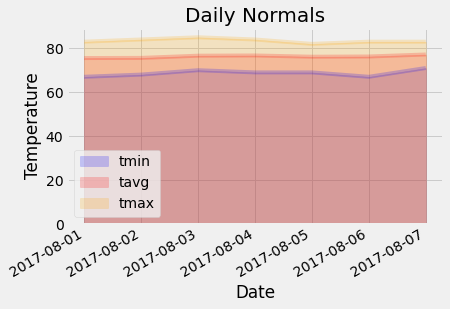

In [19]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot(kind="area", stacked=False, x_compat=True, color=["blue", "red", "orange"], alpha=.2)

plt.title("Daily Normals", size=20, y=1)

plt.ylabel("Temperature")

plt.savefig("Output/Daily_normals.png", bbox_inches = 'tight')

## Close Session

In [20]:
session.close()